In [39]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

tf.random.set_seed(42)
np.random.seed(42)


#  Genera data

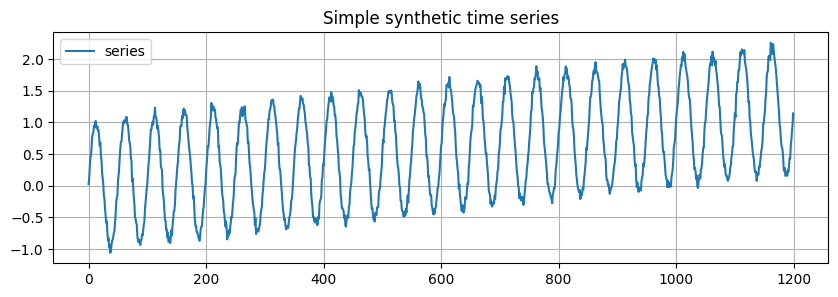

In [40]:
# --- config ---
N = 1200          # length of series
AMP = 1.0         # sine amplitude
PERIOD = 50       # sine period
TREND = 0.001     # linear trend slope
NOISE_STD = 0.05  # 0 for no noise (make it cleaner/easier)

t = np.arange(N, dtype=np.float32)
series = AMP*np.sin(2*np.pi*t/PERIOD) + TREND*t + np.random.normal(0, NOISE_STD, N)

plt.figure(figsize=(10,3))
plt.plot(series, label="series")
plt.title("Simple synthetic time series")
plt.grid(True); plt.legend(); plt.show()


# เตรียม data

In [41]:
LOOKBACK = 48   # input window length
HORIZON  = 1    # predict next step only (keep it simple)

# Scale to [0,1] for stability
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1,1)).reshape(-1)

def make_windows(series, lookback=48, horizon=1):
    X, y = [], []
    for i in range(len(series) - lookback - horizon + 1):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback:i+lookback+horizon])
    X = np.array(X, dtype=np.float32)[..., None]  # (N, lookback, 1)
    y = np.array(y, dtype=np.float32)            # (N, horizon)
    return X, y

X, y = make_windows(series_scaled, LOOKBACK, HORIZON)

# train/val/test split (70/15/15)
n = len(X)
n_train = int(n*0.7)
n_val   = int(n*0.15)

X_train, y_train = X[:n_train],           y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:],     y[n_train+n_val:]

X_train.shape, X_val.shape, X_test.shape


((806, 48, 1), (172, 48, 1), (174, 48, 1))

# Plot ให้เห็นการแบ่ง

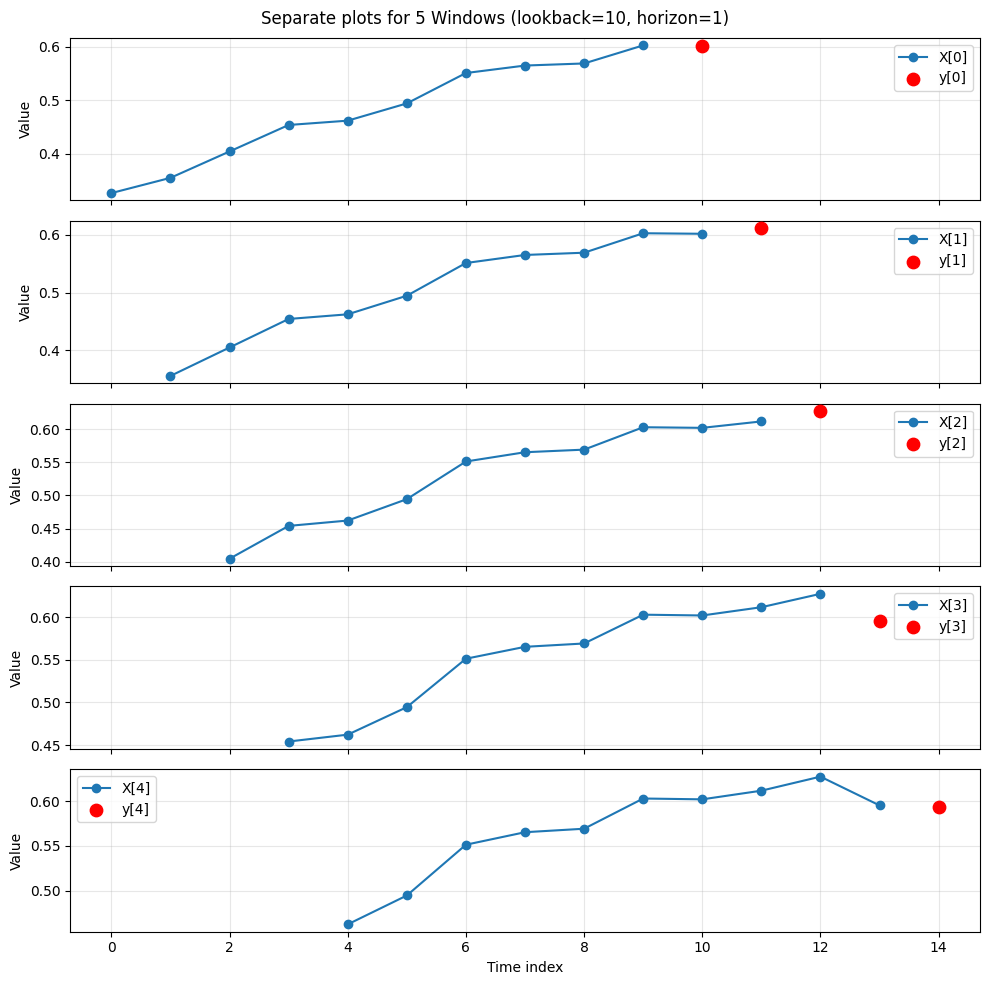

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_windows_separate(series, lookback=48, horizon=1, num_windows=5):
    X, y = make_windows(series, lookback, horizon)

    fig, axes = plt.subplots(num_windows, 1, figsize=(10, 2*num_windows), sharex=True)

    if num_windows == 1:
        axes = [axes]

    for i in range(num_windows):
        start = i
        end = i + lookback
        future = end + horizon - 1

        ax = axes[i]
        # plot window input
        ax.plot(range(start, end), series[start:end], marker="o", label=f"X[{i}]")
        # plot target y
        ax.scatter(future, series[future], color="red", s=80, zorder=5, label=f"y[{i}]")

        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(alpha=0.3)

    plt.xlabel("Time index")
    plt.suptitle(f"Separate plots for {num_windows} Windows (lookback={lookback}, horizon={horizon})")
    plt.tight_layout()
    plt.show()

# ใช้งาน (แสดง 5 windows แรก แยกเป็น 5 รูปย่อย)
plot_windows_separate(series_scaled, lookback=10, horizon=HORIZON, num_windows=5)


# Set up model

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.1456 - mae: 0.3179 - val_loss: 0.0408 - val_mae: 0.1712
Epoch 2/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0321 - mae: 0.1535 - val_loss: 0.0345 - val_mae: 0.1528
Epoch 3/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0202 - mae: 0.1232 - val_loss: 0.0151 - val_mae: 0.1084
Epoch 4/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0131 - mae: 0.1016 - val_loss: 0.0127 - val_mae: 0.0923
Epoch 5/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0073 - mae: 0.0732 - val_loss: 0.0060 - val_mae: 0.0643
Epoch 6/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0023 - mae: 0.0391 - val_loss: 0.0045 - val_mae: 0.0642
Epoch 7/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0013 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0617
Epoch 8/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0012 - mae: 0.0282 - val_loss: 0.0037 - val_mae: 0.0589
Epoch 9/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.001

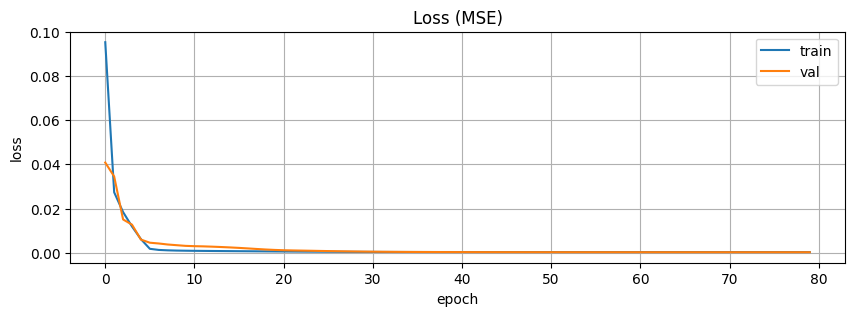

In [42]:
model = keras.Sequential([
    layers.Input(shape=(LOOKBACK, 1)),
    layers.LSTM(64),
    layers.Dense(HORIZON)          # linear output
])

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="mse", metrics=["mae"])
model.summary()

ckpt = keras.callbacks.ModelCheckpoint(
    "best_lstm.keras", monitor="val_loss",
    save_best_only=True, mode="min", verbose=0
)
early = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=8,
    restore_best_weights=True, mode="min", verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=64,
    callbacks=[ckpt, early],
    verbose=1
)

# training curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss (MSE)")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.grid(True); plt.legend(); plt.show()


# Save and test

Test MSE=0.00031 | MAE=0.01421


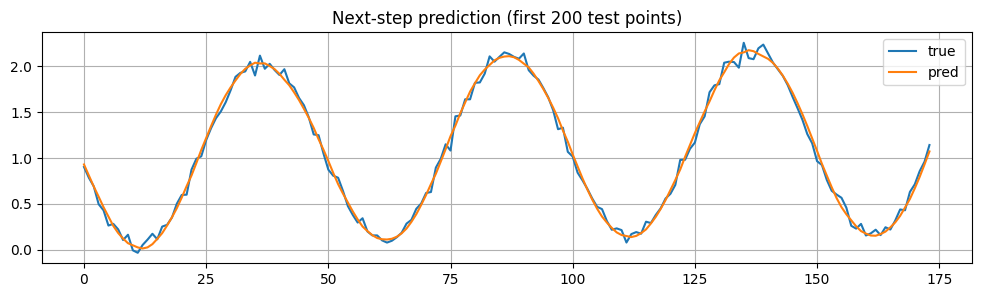

In [43]:
best = keras.models.load_model("best_lstm.keras")
test_mse, test_mae = best.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE={test_mse:.5f} | MAE={test_mae:.5f}")

# one-step prediction on test
y_pred_scaled = best.predict(X_test, verbose=0).squeeze()
y_true_scaled = y_test.squeeze()

# inverse to original scale
def inv(x): return scaler.inverse_transform(x.reshape(-1,1)).reshape(-1)
y_pred = inv(y_pred_scaled)
y_true = inv(y_true_scaled)

plt.figure(figsize=(12,3))
plt.plot(y_true[:200], label="true")
plt.plot(y_pred[:200], label="pred")
plt.title("Next-step prediction (first 200 test points)")
plt.grid(True); plt.legend(); plt.show()


# ทำนายอีก 150 step ข้างหน้า

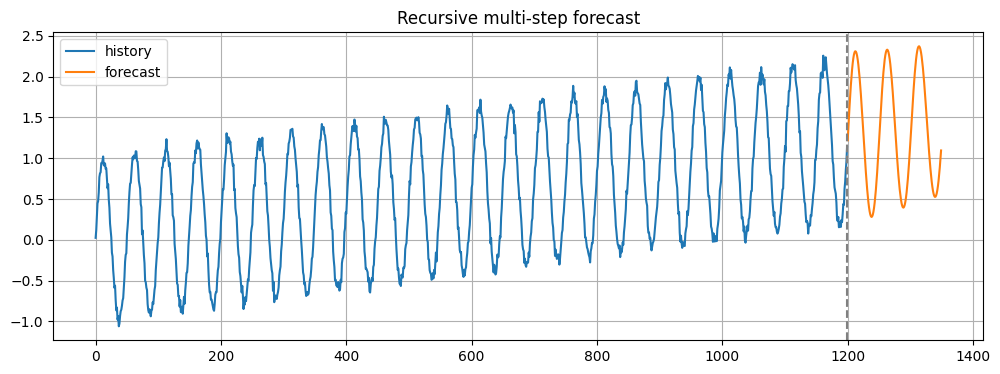

In [48]:
def forecast_recursive(model, last_window_scaled, steps_ahead=100, lookback=48, scaler=None):
    buf = np.array(last_window_scaled, dtype=np.float32).reshape(-1)  # scaled
    preds_scaled = []
    for _ in range(steps_ahead):
        x = buf[-lookback:].reshape(1, lookback, 1)
        yhat = model.predict(x, verbose=0).squeeze()
        preds_scaled.append(yhat)
        buf = np.append(buf, yhat)
    preds_scaled = np.array(preds_scaled, dtype=np.float32)
    return scaler.inverse_transform(preds_scaled.reshape(-1,1)).reshape(-1) if scaler else preds_scaled

seed_scaled = series_scaled[-LOOKBACK:]                          # scaled seed
future = forecast_recursive(best, seed_scaled, steps_ahead=150, lookback=LOOKBACK, scaler=scaler)

# plot history + forecast (with vertical split line)
plt.figure(figsize=(12,4))
plt.plot(series, label="history")
start = len(series)
plt.plot(np.arange(start, start+len(future)), future, label="forecast")
plt.axvline(start-1, ls="--", color="gray")
plt.title("Recursive multi-step forecast")
plt.grid(True); plt.legend(); plt.show()
